# Hopfield recall. Mute

Take a memory cluster, mute some nodes. See if it recalls.

Mute nodes: 1) Mute half. Show recalled signal. 2) Mute the most active. Show summary

If it works, can be an interesting application. Suppose you have a failure node in a network, but you need to know a signal. You can learn based on the previous signal to recover the signal of the failure node.

Result: recall works even if we mute signal on a half of the nodes (including the core events)

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import matplotlib.colors as colors
from scipy import sparse
# %matplotlib inline

### Prepare data

In [2]:
PATH_DATA = "/mnt/data/git/WikiBrain/src/main/resources/hopfield/"

In [3]:
#signal matrix (pages_ x time_)
content = np.load(PATH_DATA + "content.npy")

Match Wiki page ids with row numbers in <code>content</code> matrix to link it with an adjacency matrix

In [4]:
ids = []
for row in content:
    ids.append(int(row[0]))

In [5]:
ids_dict = {}
for i, a in enumerate(ids):
    ids_dict[a] = i

In [6]:
ids_dict_swap = {}
for i, a in enumerate(ids):
    ids_dict_swap[i] = a

Get cluster specific pages. Get rows of the content matrix specific to the cluster

In [7]:
CHARLIE_HEBDO = '/clusters/Charlie_Hebdo_one_week_5_12_January.csv'
GERMANWINGS = '/clusters/GermanWings_week.csv'

FERGUSON_STDDEV = '/clusters/ferguson_week_stddev.csv'
CHARLIE_STDDEV = '/clusters/charlie_week_stddev.csv'
GERMANWINGS_STDDEV = '/clusters/germanwings_week_stddev.csv'

In [8]:
FERGUSON_ADJ = '/stddev/edges_ferguson.csv'
CHARLIE_ADJ = '/stddev/edges_charlie.csv'
GERMANWINGS_ADJ = '/stddev/edges_germanwings.csv'

In [9]:
LABELS = FERGUSON_STDDEV
ADJ = FERGUSON_ADJ

In [10]:
with open(PATH_DATA + LABELS) as f:
    cluster = f.readlines()
cluster = [x.strip() for x in cluster]

In [11]:
cluster = map(lambda l: (int(l[0]), l[1]), map(lambda t: t.split(','), cluster))

In [12]:
import string
printable = set(string.printable)
cluster = map(lambda l: (int(l[0]), filter(lambda x: x in printable, l[1])), cluster)

In [13]:
cluster = dict(cluster) # (id:title)

In [14]:
#these are the nodes to mute
cluster_rows = [ids_dict[pId] for pId in cluster.keys()]

Read adjacency matrix and link it to content matrix. In other words, link signal to graph

In [15]:
import csv
with open(PATH_DATA + ADJ) as f:
    data=[tuple(line) for line in csv.reader(f)]

In [16]:
# adjacency for a cluster
list_of_ids = [ids_dict_swap[x] for x in cluster_rows]
row = [ids_dict[int(line[0])] for line in data]
col = [ids_dict[int(line[1])] for line in data]
data = [float(line[2]) if (float(line[2]) > 1.0 and int(line[0]) in list_of_ids and int(line[1]) in list_of_ids) else 0.0 for line in data] #learned

In [17]:
from scipy.sparse import csr_matrix

In [18]:
W = csr_matrix((data, (row, col)), shape=(len(ids_dict), len(ids_dict)))

In [19]:
W = W + W.transpose()

Getters by page title, row in content, and id by title

In [20]:
import csv
with open(PATH_DATA + 'id_title.csv') as f:
    data_id_title=[tuple([int(line[0]), line[1]]) for line in csv.reader(f)]

In [21]:
data_id_title = dict(data_id_title)

In [22]:
#for example
title = 'Je_suis_Charlie'

In [23]:
page_id = [ key for key,val in data_id_title.items() if val==title ][0]

In [24]:
data_id_title[page_id]

'Je_suis_Charlie'

In [25]:
nRow = ids_dict[page_id]
print 'Row number for page ' + title +  ": " + str(nRow)

Row number for page Je_suis_Charlie: 30604


In [26]:
def getTitleByRow(requested_row):
    requested_id = ids_dict_swap[requested_row]
    return data_id_title[requested_id]

Mute some nodes in the cluster. IDs to mute are in <code>cluster_rows</code>. When mutting, assign <code>-1</code>

In [27]:
#mute a particular node (e.g. Charlie Hebdo 110593, Charlie Hebdo Shooting 14957, Je suis Charlie 30604)
# content[110593] = -1
# content[14957] = -1
# content[30604] = -1

In [28]:
# content_ = content[:]

In [29]:
# mute nodes from cluster_rows
# for row in cluster_rows[:len(cluster_rows)/2]:
#     content[row] = -1

In [30]:
getTitleByRow(cluster_rows[10])

'O._J._Simpson_murder_case'

NFL cluster. Specific case. Get only team pages

In [31]:
# nfl_teams = ['Buffalo_Bills','Miami_Dolphins','New_England_Patriots','New_York_Jets','Baltimore_Ravens','Cincinnati_Bengals','Cleveland_Browns','Pittsburgh_Steelers','Houston_Texans','Indianapolis_Colts','Jacksonville_Jaguars','Tennessee_Titans','Denver_Broncos','Kansas_City_Chiefs','Los_Angeles_Chargers','Oakland_Raiders','Dallas_Cowboys','New_York_Giants','Philadelphia_Eagles','Washington_Redskins','Chicago_Bears','Detroit_Lions','Green_Bay_Packers','Minnesota_Vikings','Atlanta_Falcons','Carolina_Panthers','New_Orleans_Saints','Tampa_Bay_Buccaneers','Arizona_Cardinals','Los_Angeles_Rams','San_Francisco_49ers','Seattle_Seahawks']
# page_ids = [ key for key,val in data_id_title.items() if val in nfl_teams ]
# cluster_rows = [ids_dict[pID] for pID in page_ids]

Binarize signal (1 if active, -1 if inactive). To simplify idea of Hopfield recall process

In [32]:
# def binarize(x):
#     if x>0.0:
#         x = 1.0
#     else: x = -1.0
#     return x

In [33]:
# binarized = np.array([[binarize(x) for x in row] for row in content])

In [34]:
# binarized_ = np.array([[binarize(x) for x in row] for row in content_])

In [454]:
binarized = np.load(PATH_DATA + "binarized.npy")

In [455]:
# binarized_ = binarized[:]
import copy
binarized_ = copy.copy(binarized)

In [456]:
# fraction = len(cluster_rows) + 2
fraction = 10
for row in cluster_rows[:len(cluster_rows)/fraction]:
    binarized[row] = -1

Low pass filter to see trends in a signal

In [457]:
# def savitzky_golay(y, window_size=747, order=2, deriv=0, rate=1):
#     r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
#     The Savitzky-Golay filter removes high frequency noise from data.
#     It has the advantage of preserving the original shape and
#     features of the signal better than other types of filtering
#     approaches, such as moving averages techniques.
#     Parameters
#     ----------
#     y : array_like, shape (N,)
#         the values of the time history of the signal.
#     window_size : int
#         the length of the window. Must be an odd integer number.
#     order : int
#         the order of the polynomial used in the filtering.
#         Must be less then `window_size` - 1.
#     deriv: int
#         the order of the derivative to compute (default = 0 means only smoothing)
#     Returns
#     -------
#     ys : ndarray, shape (N)
#         the smoothed signal (or it's n-th derivative).
#     Notes
#     -----
#     The Savitzky-Golay is a type of low-pass filter, particularly
#     suited for smoothing noisy data. The main idea behind this
#     approach is to make for each point a least-square fit with a
#     polynomial of high order over a odd-sized window centered at
#     the point.
#     Examples
#     --------
#     t = np.linspace(-4, 4, 500)
#     y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
#     ysg = savitzky_golay(y, window_size=31, order=4)
#     import matplotlib.pyplot as plt
#     plt.plot(t, y, label='Noisy signal')
#     plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
#     plt.plot(t, ysg, 'r', label='Filtered signal')
#     plt.legend()
#     plt.show()
#     References
#     ----------
#     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
#        Data by Simplified Least Squares Procedures. Analytical
#        Chemistry, 1964, 36 (8), pp 1627-1639.
#     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
#        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
#        Cambridge University Press ISBN-13: 9780521880688
#     """
#     import numpy as np
#     from math import factorial

#     try:
#         window_size = np.abs(np.int(window_size))
#         order = np.abs(np.int(order))
#     except ValueError, msg:
#         raise ValueError("window_size and order have to be of type int")
#     if window_size % 2 != 1 or window_size < 1:
#         raise TypeError("window_size size must be a positive odd number")
#     if window_size < order + 2:
#         raise TypeError("window_size is too small for the polynomials order")
#     order_range = range(order+1)
#     half_window = (window_size -1) // 2
#     # precompute coefficients
#     b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
#     m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
#     # pad the signal at the extremes with
#     # values taken from the signal itself
#     firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
#     lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
#     y = np.concatenate((firstvals, y, lastvals))
#     return np.convolve( m[::-1], y, mode='valid')

Data for plotting

In [458]:
# months = ['October', 'November', 'December', 'January', 'February', 'March', 'April']
months = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
x_month = [i for i in np.arange(8*24, len(content[0]), 30*24)]
x_month[1] = x_month[1] + 24 #October
x_month[2] = x_month[2] + 24 #November
x_month[3] = x_month[3] + 48 #December
x_month[4] = x_month[4] + 72 #January
x_month[5] = x_month[5] + 24 #February
x_month[6] = x_month[6] + 48 #March
x_month[7] = x_month[7] + 48 #April

In [459]:
from pylab import rcParams
rcParams['figure.figsize'] = 140, 20
rcParams['xtick.labelsize'] = 100
rcParams['ytick.labelsize'] = 100
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

Summary of the original signal (sum activity over pages per hour)

In [460]:
# summary = np.array(csr_matrix(binarized+1).sum(axis = 0))[0]

In [461]:
#filter over 169 hours (a week) time window with a polynomial of order 2
#month = 747 hours
# filtered = savitzky_golay(summary[1:], window_size=23)

Degrade signal. Flip a fraction of activations

In [462]:
# def degrade(patterns,noise):
#     #This allows you to add noise to a pattern
#     sgn=np.vectorize(lambda x: x*-1 if np.random.random()<noise else x)
#     out=sgn(patterns)
#     return out

In [463]:
#degraded = csr_matrix(degrade(np.array(binarized), 0.2))
degraded = csr_matrix(binarized)

### Recall process

In [464]:
r,p = degraded.shape

In [465]:
def recall(W, patterns, steps=5):
    #The tests the network. You give it a pattern and see what it produces
    from numpy import vectorize, dot #vector calculus functions
    sgn = vectorize(lambda x: -1 if x<0 else +1) # convert input pattern into a -1/+1 pattern
    for _ in xrange(steps): #over a number of iterations (defined by 'steps')    
        print "." * (_ + 1)
        patterns = W.dot(patterns) #adjust the neuron activity to reflect the weights
        data = patterns.data
        patterns.data = np.array([-1 if x<0 else +1 for x in data])
    return patterns.todense() #return the final pattern

In [466]:
recalled = recall(W/r, degraded, steps=1)

.


In [467]:
#if we want to plot a cluster titles
titles = [getTitleByRow(row).decode('utf-8') for row in cluster_rows]

Plot a selected cluster

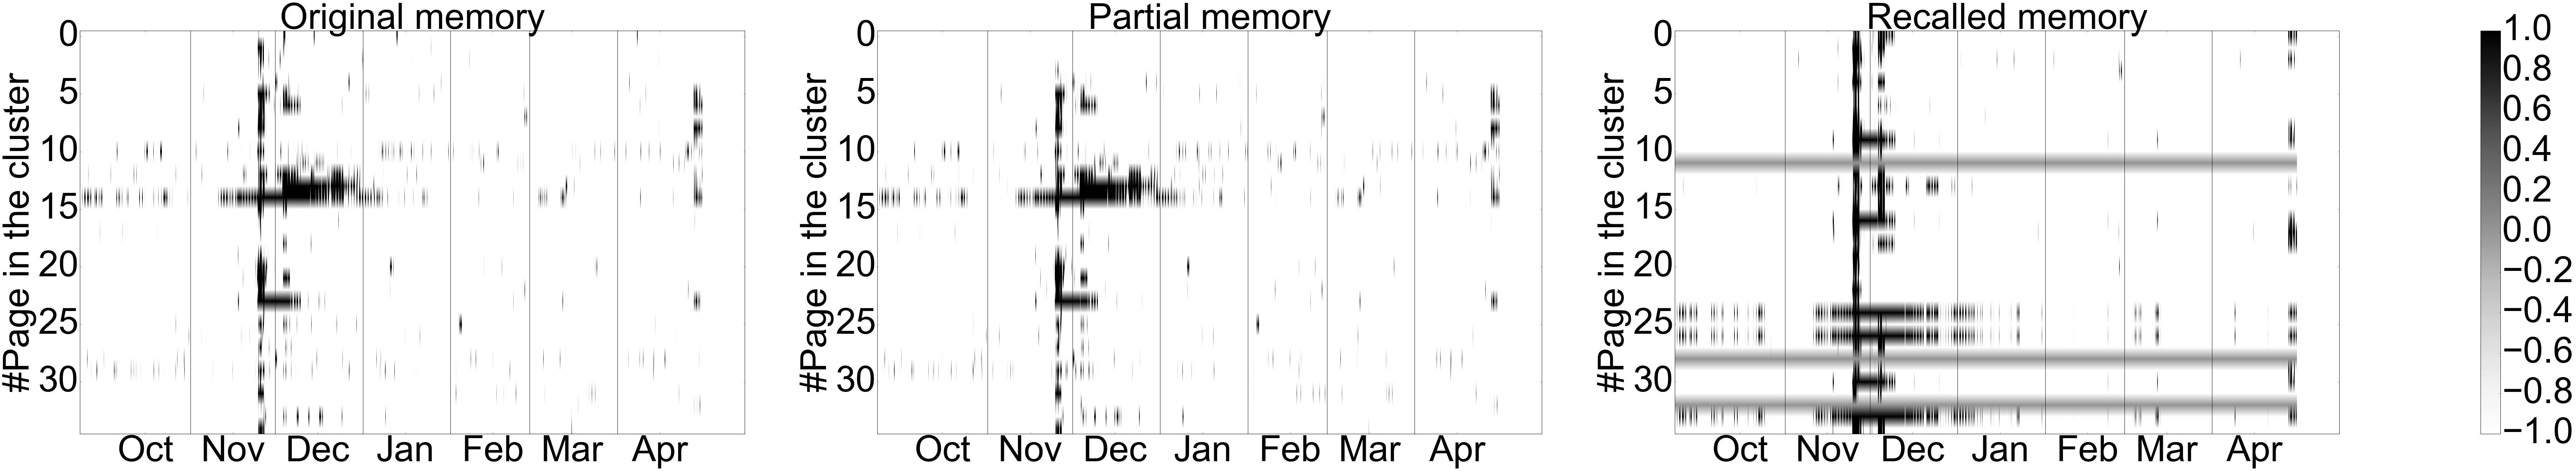

In [468]:
import numpy as np
import matplotlib.pyplot as plt

fig, ((ax1,ax2,ax3)) = plt.subplots(1,3)

axlist = [ax1,ax2,ax3]

first = ax1.imshow(binarized_[cluster_rows, :], cmap="Greys", aspect='auto')
for xc in x_month[1:7]:
    ax1.axvline(x=xc, linewidth=1, color = 'black')

    
plt.rc('axes', titlesize=100)     # fontsize of the axes title
plt.rc('axes', labelsize=100) 

ax1.set_ylabel('#Page in the cluster')
ax1.set_title('Original memory')
    
second = ax2.imshow(degraded.todense()[cluster_rows, :], cmap="Greys", aspect='auto')
for xc in x_month[1:7]:
    ax2.axvline(x=xc, linewidth=1, color = 'black')
ax2.set_ylabel('#Page in the cluster')
ax2.set_title('Partial memory')

third = ax3.imshow(recalled[cluster_rows, :], cmap="Greys", aspect='auto')
for xc in x_month[1:7]:
    ax3.axvline(x=xc, linewidth=1, color = 'black')
ax3.set_ylabel('#Page in the cluster')
ax3.set_title('Recalled memory')

pl.setp(axlist, xticks=[i + 15*24 for i in x_month], xticklabels=[month for month in months])

fig.colorbar(first, ax=axlist)

# plt.show()

In [469]:
pl.savefig("ferguson_recall.pdf", format='pdf', dpi=200)

In [470]:
# #original
# # pl.figure(figsize=(100,300))
# pl.imshow(binarized_[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month[1:-1]:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# # pl.yticks(range(0,len(titles)), titles)
# # pl.colorbar()
# pl.show()

In [471]:
# # #degraded
# # pl.figure(figsize=(100,200))
# # # pl.figure(figsize=(100,50))
# # pl.imshow(degraded.todense()[nRow-10:nRow+10, :], cmap="Greys", aspect='auto')
# pl.imshow(degraded.todense()[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# # pl.yticks(range(0,len(titles)), titles)
# # pl.colorbar()

In [472]:
# #recalled
# # pl.figure(figsize=(100,200))
# # pl.figure(figsize=(100,50))
# # pl.imshow(recalled[nRow-10:nRow+10, :], cmap="Greys", aspect='auto')
# pl.imshow(recalled[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# # pl.yticks(range(0,len(titles)), titles)
# # pl.colorbar()

In [473]:
# pl.figure(1)
# pl.subplot(331)
# pl.imshow(binarized_[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month[1:7]:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])

# pl.subplot(332)
# pl.imshow(degraded.todense()[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month[1:7]:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])

# pl.subplot(333)
# pl.imshow(recalled[cluster_rows, :], cmap="Greys", aspect='auto')
# for xc in x_month[1:7]:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])


# pl.colorbar()

Summary of the signal

In [474]:
# summary_recalled = np.array(csr_matrix(recalled+1).sum(axis = 0))[0]

In [475]:
# summary_degraded = np.array(csr_matrix(degraded.todense()[cluster_rows, :]+1).sum(axis = 0))[0]

In [476]:
# filtered_recalled = savitzky_golay(summary_recalled, window_size=23)

In [477]:
# filtered_degraded = savitzky_golay(summary_degraded, window_size=23)

In [478]:
# pl.plot(filtered_recalled - min(filtered_recalled), 'g', label="Recalled")
# pl.plot(filtered_degraded - min(filtered_degraded), 'r', label="Noisy")
# # pl.plot(filtered - min(filtered), 'b', label="Original")
# pl.legend()
# for xc in x_month:
#     pl.axvline(x=xc, linewidth=1, color = 'black')
# #pl.axvline(x = x_month[3] + 6*24, linewidth=5, color = 'b') #Charlie Hebdo
# #pl.axvline(x = x_month[3] + 24*24, linewidth=5, color = 'g') #Miss Universe
# #pl.axvline(x = x_month[3] + 9*24, linewidth=5, color = 'm') #Golden Globe
# pl.xticks([i + 15*24 for i in x_month], [month for month in months])
# pl.show()

Compute error

In [479]:
original = copy.copy(binarized_[cluster_rows, :])
actual = copy.copy(np.array(recalled[cluster_rows, :]))

In [480]:
a = np.array([[1,0], [3,0], [5,6], [7,8]])
a_ = np.array([[1,0], [3,4], [5,6], [7,7]])

In [481]:
# a.flatten()

In [482]:
def compute_error(original, recalled):
    o = original.flatten()
    r = recalled.flatten()
    sum = 0
    for i in range(0,len(o)):
        if o[i] != r[i] and o[i] == 1:
            sum += 1
    return sum*1.0/len([x for x in o if x == 1])

In [483]:
compute_error(original, actual)

0.6764021164021164

In [441]:
# 2 : 0.023126674424268665

In [442]:
# 1: 0.02557302519416556

In [443]:
# 5: 0.018899683381592834

In [444]:
# all: 0.017189402754850758

Number of remembered activations / number of actual activations

In [445]:
# all: 0.6721693121693122

In [446]:
# 1 (none): 1.0

In [447]:
# 2 (half): 0.9043386243386243

In [448]:
# 3 (third): 0.7623280423280423

In [449]:
# 4 (quater): 0.7428571428571429

In [450]:
# 5 (20%): 0.7390476190476191

In [ ]:
# 10 (10%): 

In [451]:
%matplotlib inline

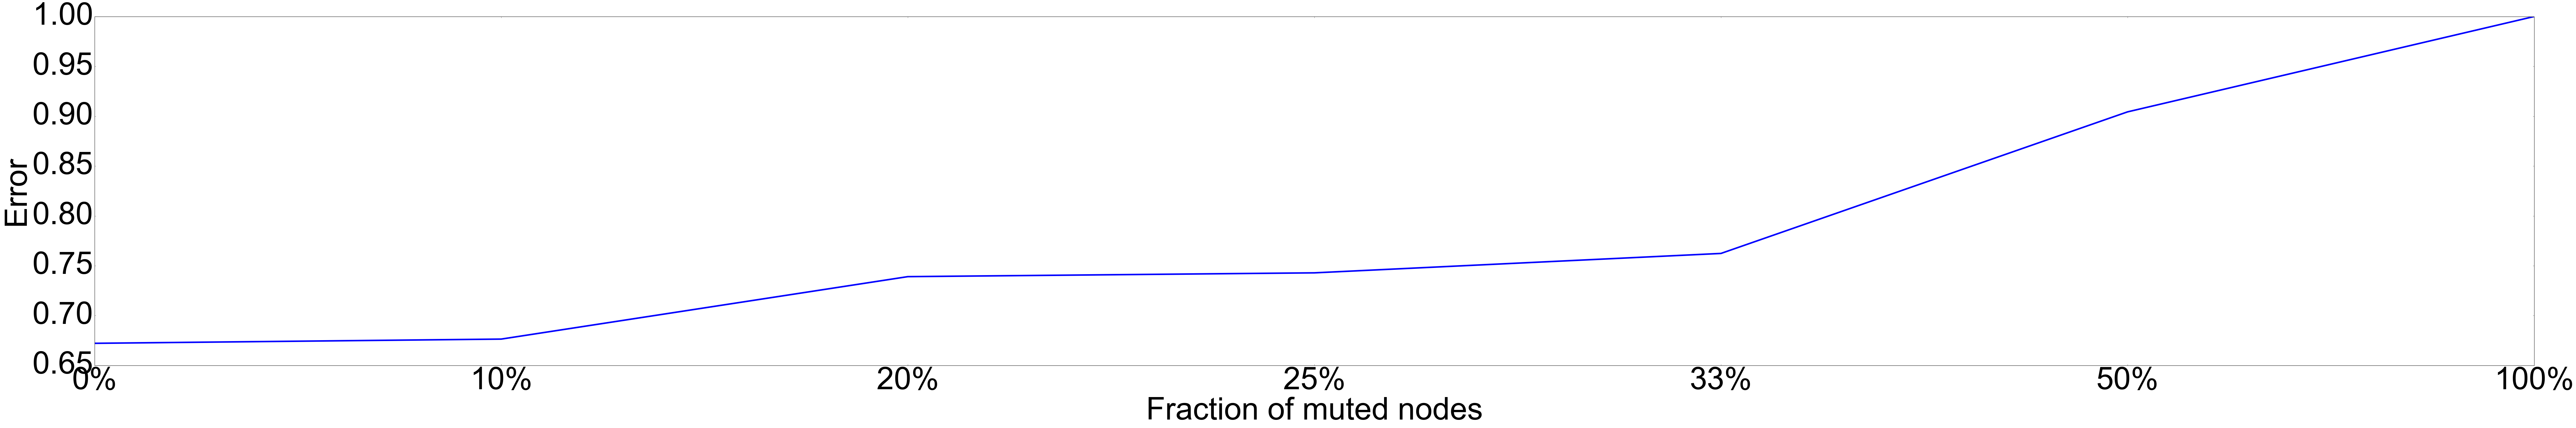

In [489]:
pl.plot([0.6721693121693122, 0.6764021164021164, 0.7390476190476191, 0.7428571428571429, 0.7623280423280423, 0.9043386243386243, 1.0], linewidth=5)
pl.xticks([0,1,2,3,4,5,6], ['0%', '10%', '20%', '25%', '33%', '50%', '100%'])
pl.ylabel('Error')
pl.xlabel('Fraction of muted nodes')